## Covid19 India Analysis and Forecast

## Introduction

This project aims to provide interactive visualizations on the various COVID-19 statistics such as mortality, vaccination rates, confirmed and recovered cases as both absolute and relative of population in India across all states/UT's and districts.


## Data source

Data is obtained from the Covid19 API(https://data.covid19india.org) and the corresponding json and csv responses are then streamed using Kafka and Spark Streaming and persisited onto a Cassandra database. Static visualizations using plots/graphs etc and a time-series animated visualizations are demonstrated at both state and district level for  absolute and relative metrics such as "Total Confirmed", "Total Recovered", "Total Deceased" and "Total Vaccinated". The below diagram explains the flow for the data from API to database.
<br><img src="Pipeline.jpg"/><br>

## Commands for kafka producer and consumer
<br></br>
### <u>Districts<u>
### python kafka_district_stats_daily_consumer.py (for kafka consumer)
### python kafka_district_stats_daily_producer.py (for kafka producer)
<br></br>
### <u>States</u>
### python kafka_ind_stats_daily_consumer.py (for kafka consumer)
### python kafka_ind_stats_daily_producer.py (for kafka producer)

### Necessary imports

In [1]:
# !pip install cassandra-driver
from pyspark.sql import *
from cassandra.cluster import Cluster
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
import datetime
import seaborn as sns; sns.set_style('darkgrid')
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import os
import requests
import plotly.express as px
from io import StringIO
from pandas import to_datetime
import re
import warnings
warnings.simplefilter(action='ignore')

cassandra_ip = '172.19.0.3'

def Save_Spark_DataFrame(df,path="./covid19_data/test"):
    df.coalesce(1)\
          .write\
          .option("header","true")\
          .option("sep",",")\
          .mode("overwrite")\
          .csv(path)

## Covid19India API will no longer be operational after 31st October 2021

### Links to fetch data from API

In [2]:
time_series = "https://api.covid19india.org/v4/min/timeseries.min.json"	#Daily numbers across C,R,D and Tested per state (historical data).
district_state = "https://api.covid19india.org/v4/min/data.min.json"	#Current day numbers across districts and states.
states = "https://api.covid19india.org/csv/latest/states.csv"#Statewise timeseries of Confirmed, Recovered and Deceased numbers.
districts = "https://api.covid19india.org/csv/latest/districts.csv" #Districtwise timeseries of Confirmed, Recovered and Deceased numbers.
state_wise_daily="https://api.covid19india.org/csv/latest/state_wise_daily.csv" #Statewise per day delta of Confirmed, Recovered and Deceased numbers.
state_wise="https://api.covid19india.org/csv/latest/state_wise.csv" #Statewise cumulative numbers till date.
district_wise="https://api.covid19india.org/csv/latest/district_wise.csv"	#Districtwise Cumulative numbers till date.
vaccine_doses_administered_statewise="http://api.covid19india.org/csv/latest/vaccine_doses_statewise_v2.csv"#Number of vaccine doses administered statewise - Collected from MOHFW daily bulletin
cowin_vaccine_data_statewise="http://api.covid19india.org/csv/latest/cowin_vaccine_data_statewise.csv"	#Key data points from CoWin database at a state level
cowin_vaccine_data_districtwise="http://api.covid19india.org/csv/latest/cowin_vaccine_data_districtwise.csv"	#Key data points from CoWin database at a district level

Datasets in this notebook has been fetched from https://data.covid19india.org

In [3]:
# !wget -O ./covid19_data/states.csv https://api.covid19india.org/csv/latest/states.csv
# !wget -O ./covid19_data/districts.csv https://api.covid19india.org/csv/latest/districts.csv
# !wget -O ./covid19_data/state_wise_daily.csv https://api.covid19india.org/csv/latest/state_wise_daily.csv
# !wget -O ./covid19_data/state_wise.csv https://api.covid19india.org/csv/latest/state_wise.csv
# !wget -O ./covid19_data/district_wise.csv https://api.covid19india.org/csv/latest/district_wise.csv
# !wget -O ./covid19_data/vaccine_doses_statewise_v2.csv http://api.covid19india.org/csv/latest/vaccine_doses_statewise_v2.csv
# !wget -O ./covid19_data/cowin_vaccine_data_statewise.csv http://api.covid19india.org/csv/latest/cowin_vaccine_data_statewise.csv
# !wget -O ./covid19_data/cowin_vaccine_data_districtwise.csv http://api.covid19india.org/csv/latest/cowin_vaccine_data_districtwise.csv
# !wget -O ./covid19_data/Cumulative_Cases_Per_District.json https://api.covid19india.org/v4/min/timeseries.min.json
# !wget -O ./covid19_data/Current_Day_Cases_Per_District.json https://api.covid19india.org/v4/min/data.min.json

### Creating a Spark Session to connect to Cassndra

In [4]:
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--master local[2] pyspark-shell'
spark = SparkSession.builder.appName('Final_Project')\
        .config("spark.cassandra.connection.host",cassandra_ip)\
        .config("spark.driver.allowMultipleContexts", "true")\
        .getOrCreate()

### Reading from Cassandra into a spark dataframe and Caching to improve access speeds

In [8]:
ind_district_stats = spark.read.format("org.apache.spark.sql.cassandra").options(table="india_district_daily_statistics", keyspace="covid_slots").load()
ind_district_stats.cache()
print("Total records - ",ind_district_stats.count())
ind_district_stats.printSchema()

Total records -  346103
root
 |-- date: date (nullable = false)
 |-- state: string (nullable = true)
 |-- district: string (nullable = true)
 |-- confirmed_total: integer (nullable = true)
 |-- deceased_total: integer (nullable = true)
 |-- other_total: integer (nullable = true)
 |-- recovered_total: integer (nullable = true)
 |-- tested_total: integer (nullable = true)



In [9]:
# ind_district_stats.unpersist()

### Removing Districts that cannot be plotted on the map

In [10]:
ind_district_stats = ind_district_stats.where((col('District') !='Unknown') & \
                                              (col('District') !='Airport Quarantine') & \
                                              (col('District') !='BSF Camp') & \
                                              (col('District') !='Capital Complex') & \
                                              (col('District') !='Evacuees') & \
                                              (col('District') !='Foreign Evacuees') & \
                                              (col('District') !='Italians') & \
                                              (col('District') !='Others') & \
                                              (col('District') !='Other State') & \
                                              (col('District') !='Other Region') & \
                                              (col('District') !='Railway Quarantine') & \
                                              (col('District') !='State Pool') & \
                                              (col('confirmed_total') != 0))

                                             
ind_district_stats = ind_district_stats.drop('other_total')
# ind_district_stats = ind_district_stats.drop('other_total','deceased_total')

for cols in 'confirmed_total|recovered_total|deceased_total|tested_total'.split('|'):
    ind_district_stats = ind_district_stats.withColumn(cols,when(col(cols).isNull(),0).otherwise(col(cols)))
ind_district_stats = ind_district_stats.withColumn('recovered_total',when(col('recovered_total') > col('confirmed_total'),col('confirmed_total')).otherwise(col('recovered_total')))
# ind_district_stats = ind_district_stats.withColumn('deceased_total',col('confirmed_total')-col('recovered_total'))
ind_district_stats = ind_district_stats.withColumn('Date',to_date(col('Date')).cast(DateType()))
ind_district_stats.printSchema()
print(ind_district_stats.count())

root
 |-- Date: date (nullable = false)
 |-- state: string (nullable = true)
 |-- district: string (nullable = true)
 |-- confirmed_total: integer (nullable = true)
 |-- deceased_total: integer (nullable = true)
 |-- recovered_total: integer (nullable = true)
 |-- tested_total: integer (nullable = true)

331809


In [11]:
ind_district_stats = ind_district_stats.orderBy(desc('Date'),'State','District')
ind_district_stats.show()

+----------+-----------------+--------------+---------------+--------------+---------------+------------+
|      Date|            state|      district|confirmed_total|deceased_total|recovered_total|tested_total|
+----------+-----------------+--------------+---------------+--------------+---------------+------------+
|2021-10-12|   Andhra Pradesh|     Anantapur|         157706|          1093|         156544|      787085|
|2021-10-12|   Andhra Pradesh|      Chittoor|         245284|          1930|         242263|      780322|
|2021-10-12|   Andhra Pradesh| East Godavari|         292576|          1286|         289856|      944746|
|2021-10-12|   Andhra Pradesh|        Guntur|         176975|          1226|         175113|      833823|
|2021-10-12|   Andhra Pradesh|       Krishna|         118244|          1401|         115955|      782232|
|2021-10-12|   Andhra Pradesh|       Kurnool|         124068|           852|         123179|      867361|
|2021-10-12|   Andhra Pradesh|      Prakasam| 

### Dataframe consisting of district wise Latitude and Longitudes

In [12]:
district_lat_long = spark.read.csv('./covid19_data/district_lat_long_pop.csv',header=True,inferSchema=True).drop('state')
district_lat_long.show(5)

+----------+----------+----------+-----------+
|  district|population|  latitude|  longitude|
+----------+----------+----------+-----------+
|  Adilabad|    708952|      19.5|       78.5|
|Agar Malwa|    571275|23.9342963|76.14523314|
|      Agra|   4380793|27.1752554| 78.0098161|
| Ahmedabad|   7208200|23.0216238| 72.5797068|
|Ahmednagar|   4543083|19.1627725| 74.8580243|
+----------+----------+----------+-----------+
only showing top 5 rows



### Performing a left-outer join between the data and the co-ordinates dataframes

In [13]:
ind_district_stats = ind_district_stats.alias('df1')
district_lat_long = district_lat_long.alias('df2')

ind_district_stats = ind_district_stats.join(district_lat_long,ind_district_stats.district == district_lat_long.district,'left_outer')\
                  .select(['Date','state','df1.district','population','latitude','longitude','confirmed_total','deceased_total','recovered_total','tested_total'])


### Calculating percentage metrics for "Confirmed" & "Tested" and Percentage of "Recovered" & "Deceased" out of "Total Confirmed"

In [14]:
ind_district_stats = ind_district_stats.withColumn('days_since_first_case',datediff(col("Date"),lit('2020-04-25'))).orderBy(desc('Date'),'District')
ind_district_stats = ind_district_stats.withColumn('latitude',col('latitude').cast(DoubleType()))
ind_district_stats = ind_district_stats.withColumn('longitude',col('longitude').cast(DoubleType()))
for cols in 'confirmed_total|tested_total'.split('|'):
    ind_district_stats = ind_district_stats.withColumn(cols+'_relative',round((col(cols)/col('population'))*100,2))

for cols in 'deceased_total|recovered_total'.split('|'):
    ind_district_stats = ind_district_stats.withColumn(cols+'_relative',round((col(cols)/col('confirmed_total'))*100,2))
    
    
ind_district_stats.printSchema()
ind_district_stats.orderBy(desc("Date"),desc('deceased_total_relative')).show(10)

root
 |-- Date: date (nullable = false)
 |-- state: string (nullable = true)
 |-- district: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- confirmed_total: integer (nullable = true)
 |-- deceased_total: integer (nullable = true)
 |-- recovered_total: integer (nullable = true)
 |-- tested_total: integer (nullable = true)
 |-- days_since_first_case: integer (nullable = true)
 |-- confirmed_total_relative: double (nullable = true)
 |-- tested_total_relative: double (nullable = true)
 |-- deceased_total_relative: double (nullable = true)
 |-- recovered_total_relative: double (nullable = true)

+----------+--------+--------------------+----------+-----------+-----------+---------------+--------------+---------------+------------+---------------------+------------------------+---------------------+-----------------------+------------------------+
|      Date|   state|            distric

### Checking for Null values in the fields

In [15]:
ind_district_stats.select([count(when(col(c).isNull(), c)).alias(c) for c in ind_district_stats.columns]).show()

+----+-----+--------+----------+--------+---------+---------------+--------------+---------------+------------+---------------------+------------------------+---------------------+-----------------------+------------------------+
|Date|state|district|population|latitude|longitude|confirmed_total|deceased_total|recovered_total|tested_total|days_since_first_case|confirmed_total_relative|tested_total_relative|deceased_total_relative|recovered_total_relative|
+----+-----+--------+----------+--------+---------+---------------+--------------+---------------+------------+---------------------+------------------------+---------------------+-----------------------+------------------------+
|   0|    0|       0|         0|       0|        0|              0|             0|              0|           0|                    0|                       0|                    0|                      0|                       0|
+----+-----+--------+----------+--------+---------+---------------+-------------

### Reading in state-wise data from Cassandra

In [16]:
ind_stats_daily = spark.read.format("org.apache.spark.sql.cassandra").options(table="india_daily_statistics", keyspace="covid_slots").load()

ind_stats_daily = ind_stats_daily.drop('deceased_total')
ind_stats_daily = ind_stats_daily.withColumn('deceased_total',col('confirmed_total')-col('recovered_total'))
ind_stats_daily = ind_stats_daily.withColumn('date',to_date(col('date')).cast(DateType()))

ind_stats_daily.printSchema()
ind_stats_daily.orderBy(desc('date'),desc("state")).show(5)
ind_stats_daily.count()

root
 |-- date: date (nullable = false)
 |-- state: string (nullable = true)
 |-- cfr: double (nullable = true)
 |-- cfr_week_window: double (nullable = true)
 |-- confirmed: integer (nullable = true)
 |-- confirmed_total: integer (nullable = true)
 |-- confirmed_week_window: integer (nullable = true)
 |-- deceased: integer (nullable = true)
 |-- deceased_week_window: integer (nullable = true)
 |-- recovered: integer (nullable = true)
 |-- recovered_total: integer (nullable = true)
 |-- recovered_week_window: integer (nullable = true)
 |-- tpr: double (nullable = true)
 |-- tpr_week_window: double (nullable = true)
 |-- vaccinated1: integer (nullable = true)
 |-- vaccinated1_total: integer (nullable = true)
 |-- vaccinated1_week_window: integer (nullable = true)
 |-- vaccinated2: integer (nullable = true)
 |-- vaccinated2_total: integer (nullable = true)
 |-- vaccinated2_week_window: integer (nullable = true)
 |-- deceased_total: integer (nullable = true)

+----------+-------------+---

20310

In [17]:
ind_stats_daily.select([count(when(col(c).isNull(), c)).alias(c) for c in ind_stats_daily.columns]).show()

+----+-----+---+---------------+---------+---------------+---------------------+--------+--------------------+---------+---------------+---------------------+---+---------------+-----------+-----------------+-----------------------+-----------+-----------------+-----------------------+--------------+
|date|state|cfr|cfr_week_window|confirmed|confirmed_total|confirmed_week_window|deceased|deceased_week_window|recovered|recovered_total|recovered_week_window|tpr|tpr_week_window|vaccinated1|vaccinated1_total|vaccinated1_week_window|vaccinated2|vaccinated2_total|vaccinated2_week_window|deceased_total|
+----+-----+---+---------------+---------+---------------+---------------------+--------+--------------------+---------+---------------+---------------------+---+---------------+-----------+-----------------+-----------------------+-----------+-----------------+-----------------------+--------------+
|   0|    0|  0|              0|        0|              0|                    0|       0|     

### State-wise Latitudes and Longitudes

In [18]:
ind_lat_long = spark.read.csv('./covid19_data/india-states-statistics.csv',header=True,inferSchema=True)
ind_lat_long.printSchema()
ind_lat_long.show()

root
 |-- state: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- Population: integer (nullable = true)
 |-- Sex ratio: integer (nullable = true)
 |-- Area(km2): integer (nullable = true)
 |-- Density(per km2): double (nullable = true)
 |-- Literacy Rate: double (nullable = true)

+--------------------+-----------+-----------+----------+---------+---------+----------------+-------------+
|               state|   latitude|  longitude|Population|Sex ratio|Area(km2)|Density(per km2)|Literacy Rate|
+--------------------+-----------+-----------+----------+---------+---------+----------------+-------------+
|Andaman and Nicob...|11.66702557|92.73598262|    417036|      876|     8249|           50.56|        86.63|
|      Andhra Pradesh| 14.7504291|78.57002559|  53903393|      996|   162968|          330.76|        67.02|
|   Arunachal Pradesh|27.10039878|93.61660071|   1570458|      938|    83743|           18.75|        65.38|
| 

### Joining State-wise data and co-ordinates

In [19]:
ind_stats_daily = ind_stats_daily.alias('df1')
ind_lat_long = ind_lat_long.alias('df2')

ind_stats_daily = ind_stats_daily.join(ind_lat_long,ind_stats_daily.state == ind_lat_long.state,'left_outer')\
                  .select(['Date','df1.state','population','latitude','longitude','confirmed_total','deceased_total','recovered_total','vaccinated1_total','vaccinated2_total'])
ind_stats_daily.orderBy(desc('Date')).show()

+----------+--------------------+----------+-----------+-----------+---------------+--------------+---------------+-----------------+-----------------+
|      Date|               state|population|   latitude|  longitude|confirmed_total|deceased_total|recovered_total|vaccinated1_total|vaccinated2_total|
+----------+--------------------+----------+-----------+-----------+---------------+--------------+---------------+-----------------+-----------------+
|2021-10-12|              Odisha|  46356334|  20.479712|  84.233147|        1032673|         12909|        1019764|         23523302|          9531355|
|2021-10-12|   Jammu and Kashmir|  13606320|34.29995933|74.46665849|         330666|          5419|         325247|          9162264|          4046393|
|2021-10-12|            Nagaland|   2249695| 25.6669979|94.11657019|          31492|          1935|          29557|           696064|           416789|
|2021-10-12|        Chhattisgarh|  29436231|22.09042035|82.15998734|        1005570|    

### Check for Null values

In [20]:
ind_stats_daily.select([count(when(col(c).isNull(), c)).alias(c) for c in ind_stats_daily.columns]).show()
ind_stats_daily.printSchema()

+----+-----+----------+--------+---------+---------------+--------------+---------------+-----------------+-----------------+
|Date|state|population|latitude|longitude|confirmed_total|deceased_total|recovered_total|vaccinated1_total|vaccinated2_total|
+----+-----+----------+--------+---------+---------------+--------------+---------------+-----------------+-----------------+
|   0|    0|         0|       0|        0|              0|             0|              0|                0|                0|
+----+-----+----------+--------+---------+---------------+--------------+---------------+-----------------+-----------------+

root
 |-- Date: date (nullable = false)
 |-- state: string (nullable = true)
 |-- population: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- confirmed_total: integer (nullable = true)
 |-- deceased_total: integer (nullable = true)
 |-- recovered_total: integer (nullable = true)
 |-- vaccinated1_total: i

### Calculating percentage metrics for "Confirmed" & "Tested" and Percentage of "Recovered" & "Deceased" out of "Total Confirmed"

In [21]:
ind_stats_daily = ind_stats_daily.withColumn('days_since_first_case',datediff(col("Date"),lit('2020-01-30'))).orderBy(desc('Date'),'State')
ind_stats_daily = ind_stats_daily.withColumn('latitude',col('latitude').cast(DoubleType()))
ind_stats_daily = ind_stats_daily.withColumn('longitude',col('longitude').cast(DoubleType()))
for cols in 'confirmed_total|vaccinated1_total|vaccinated2_total'.split('|'):
    ind_stats_daily = ind_stats_daily.withColumn(cols+'_relative',round((col(cols)/col('population'))*100,2))

for cols in 'deceased_total|recovered_total'.split('|'):
    ind_stats_daily = ind_stats_daily.withColumn(cols+'_relative',round((col(cols)/col('confirmed_total'))*100,2))
    
ind_stats_daily.orderBy(desc('Date')).show(10)

+----------+--------------------+----------+-----------+-----------+---------------+--------------+---------------+-----------------+-----------------+---------------------+------------------------+--------------------------+--------------------------+-----------------------+------------------------+
|      Date|               state|population|   latitude|  longitude|confirmed_total|deceased_total|recovered_total|vaccinated1_total|vaccinated2_total|days_since_first_case|confirmed_total_relative|vaccinated1_total_relative|vaccinated2_total_relative|deceased_total_relative|recovered_total_relative|
+----------+--------------------+----------+-----------+-----------+---------------+--------------+---------------+-----------------+-----------------+---------------------+------------------------+--------------------------+--------------------------+-----------------------+------------------------+
|2021-10-12|             Haryana|  28204692|  29.102377|  75.965996|         771009|         1

In [22]:
## Neccessary libraries for the below code to work

# !pip install streamlit
# !pip install pydeck
# !pip install vega_datasets
# !pip install palettable
# !pip install panel

In [23]:
import pydeck as pdk
import pandas as pd
from vega_datasets import data as vds
import ipywidgets
from palettable.cartocolors.sequential import BrwnYl_3
import json
import os
import streamlit as st
import ipywidgets as widgets
import panel as pn
from IPython.display import Markdown, display
import time

pn.extension()

os.environ['MAPBOX_API_KEY'] = "pk.eyJ1IjoicHJhandhbC1yIiwiYSI6ImNrdDQ2bGZvbjExOXIzNnBnb3oxMHZiazcifQ.Vbs6Gsn2-B1kxLPfUE0-Tg"
### To enable pydeck for Jupyter Notebook:
# jupyter nbextension install --sys-prefix --symlink --overwrite --py pydeck
# jupyter nbextension enable --sys-prefix --py pydeck

## Creating Interactive Widgets for visualisation

In [24]:
def Interactive_Map(df,field,graph_params,State_Dist):
    view = pdk.ViewState(latitude=df.latitude.mean(),
                         longitude=df.longitude.mean(), pitch=50, zoom=3.5)
    
    if State_Dist == 'District-wise':
        if "relative" in field:
            html = '''<b>Percentage %s:</b> {%s}
                          <br>
                          <b>State:</b> {district}''' %(field.split("_")[0],field)
            display(Markdown("**District-wise Percentage %s**"%(field.split("_")[0])))
        else:
            html = '''<b>Total %s:</b> {%s}
                          <br>
                          <b>State:</b> {district}''' %(field.split("_")[0],field)
            display(Markdown("**District-wise Total %s**"%(field.split("_")[0])))
    
    elif State_Dist == 'State-wise':
        if "relative" in field:
            html = '''<b>Percentage %s:</b> {%s}
                          <br>
                          <b>State:</b> {state}''' %(field.split("_")[0],field)
            display(Markdown("**State-wise Percentage %s**"%(field.split("_")[0])))
                    
        else:
            html = '''<b>Total %s:</b> {%s}
                          <br>
                          <b>State:</b> {state}''' %(field.split("_")[0],field)
            display(Markdown("**State-wise Total %s**"%(field.split("_")[0])))
                    

    tooltip = {
       "html": html,
       "style": {
            "backgroundColor": "steelblue",
            "color": "white"
       }
    }
    column_layer = pdk.Layer('ColumnLayer',
                            data=df,
                            get_position=['longitude', 'latitude'],
                            get_elevation=field,
                            elevation_scale=graph_params[field]['elevation_scale'],
                            radius=graph_params[field]['radius'],
                            get_fill_color=graph_params[field]['get_fill_color'],
                            pickable=True,
                            auto_highlight=True)

    column_layer_map = pdk.Deck(layers=column_layer, 
                                initial_view_state=view,map_provider='mapbox',tooltip=tooltip)

    # widgets
    slider = ipywidgets.IntSlider(value=1, min=1, max=df.days_since_first_case.max()-1, step=1)
    play = ipywidgets.Play(value=1, min=1, max=df.days_since_first_case.max()-1, step=1, description='Press play', interval=1)
    ipywidgets.jslink((play, 'value'), (slider, 'value'))
    layout = ipywidgets.HBox([slider, play])
    
    def update_plot_district(days_since_first_case):
        column_layer.data = df[df['days_since_first_case'] == days_since_first_case]
        if dropdown_state_dist.value == 'District-wise':
            date_slider = pn.widgets.DateSlider(name='Date Slider', start=datetime.datetime(2020, 4, 25), 
                                                end=datetime.datetime(2020, 4, 25)+datetime.timedelta(days=df.days_since_first_case.max()), 
                                                value=datetime.datetime(2020, 4, 25)+datetime.timedelta(days=days_since_first_case))
            
        elif dropdown_state_dist.value == 'State-wise':
            date_slider = pn.widgets.DateSlider(name='Date Slider', start=datetime.datetime(2020, 1, 30), 
                                                end=datetime.datetime(2020, 1, 30)+datetime.timedelta(days=df.days_since_first_case.max()), 
                                                value=datetime.datetime(2020, 1, 30)+datetime.timedelta(days=days_since_first_case))
            
        display(Markdown("**Date - "+date_slider.value.strftime('%d-%m-%Y')+"**"))
        return column_layer_map.update()
    
    # interaction between widget and function
    interact = ipywidgets.interactive_output(update_plot_district, {'days_since_first_case': slider});
    display(layout, interact)

    column_layer_map.to_html('time-series.html')
    display(column_layer_map.show())

## Time-series Animated Visualisation of Covid19 statistics

In [25]:
output_year = widgets.Output()
plot_output = widgets.Output()
item_layout = widgets.Layout(margin='0 0 50px 0')

dropdown_state_dist = widgets.Dropdown(options = ['State-wise','District-wise'],value='District-wise')
dropdown_abs_rel = widgets.Dropdown(options = ['Absolute','Relative'],value='Absolute')
dropdown_type = widgets.Dropdown(options = ['confirmed_total','recovered_total','deceased_total','tested_total'],value='recovered_total')
graph_params_state = {'confirmed_total' :          {'elevation_scale':0.3, 'radius':30000, 'get_fill_color':[68,188,216, 150]},
                        'confirmed_total_relative' : {'elevation_scale':60000, 'radius':30000, 'get_fill_color':[68,188,216, 150]},
                        'recovered_total' :          {'elevation_scale':0.3, 'radius':30000, 'get_fill_color':[37, 204, 59, 150]},
                        'recovered_total_relative' : {'elevation_scale':6000, 'radius':30000, 'get_fill_color':[37, 204, 59, 150]},
                        'deceased_total' :           {'elevation_scale':5.0, 'radius':30000, 'get_fill_color':[255, 255, 255, 150]},
                        'deceased_total_relative' :  {'elevation_scale':2000, 'radius':30000, 'get_fill_color':[255, 255, 255, 150]},
                        'tested_total' :             {'elevation_scale':0.3, 'radius':30000, 'get_fill_color':[191, 134, 235, 150]},
                        'tested_total_relative' :    {'elevation_scale':7500, 'radius':30000, 'get_fill_color':[191, 134, 235, 150]},
                        'vaccinated1_total' :        {'elevation_scale':0.05, 'radius':30000, 'get_fill_color':[68,188,216, 150]},
                        'vaccinated1_total_relative':{'elevation_scale':7500, 'radius':30000, 'get_fill_color':[68,188,216, 150]},
                        'vaccinated2_total' :        {'elevation_scale':0.1, 'radius':30000, 'get_fill_color':[68,188,216, 150]},
                        'vaccinated2_total_relative':{'elevation_scale':12000, 'radius':30000, 'get_fill_color':[68,188,216, 150]},
                       }

graph_params_district = {'confirmed_total' :     {'elevation_scale':0.6, 'radius':10000, 'get_fill_color':[68,188,216, 150]},
                    'confirmed_total_relative' : {'elevation_scale':30000, 'radius':10000, 'get_fill_color':[68,188,216, 150]},
                    'recovered_total' :          {'elevation_scale':0.6, 'radius':10000, 'get_fill_color':[37, 204, 59, 150]},
                    'recovered_total_relative' : {'elevation_scale':3000, 'radius':10000, 'get_fill_color':[37, 204, 59, 150]},
                    'deceased_total' :           {'elevation_scale':25.0, 'radius':10000, 'get_fill_color':[255, 255, 255, 150]},
                    'deceased_total_relative' :  {'elevation_scale':30000, 'radius':10000, 'get_fill_color':[255, 255, 255, 150]},
                    'tested_total' :             {'elevation_scale':0.3, 'radius':10000, 'get_fill_color':[191, 134, 235, 150]},
                    'tested_total_relative' :    {'elevation_scale':7500, 'radius':10000, 'get_fill_color':[191, 134, 235, 150]},
                    }

def dropdown_type_eventhandler(metric):
    plot_output.clear_output()
    with plot_output:
        if dropdown_state_dist.value == 'District-wise':
            df = ind_district_stats.select(['Date','district','latitude','longitude','days_since_first_case',metric.new]).toPandas()
            df['Date'] = pd.to_datetime(df['Date'])
            Interactive_Map(df,metric.new,graph_params_district,dropdown_state_dist.value)
            
        elif dropdown_state_dist.value == 'State-wise':
            df = ind_stats_daily.select('Date', 'state',metric.new ,'latitude', 'longitude','days_since_first_case').toPandas()
            df['Date'] = pd.to_datetime(df['Date'])
            Interactive_Map(df,metric.new,graph_params_state,dropdown_state_dist.value)
            
def dropdown_abs_rel_eventhandler(Abs_Rel):
    output_year.clear_output()
    with output_year:
        print(dropdown_state_dist.value)
        if dropdown_state_dist.value == 'District-wise':
            if Abs_Rel.new == 'Relative':
                dropdown_type.options = ['confirmed_total_relative','recovered_total_relative','deceased_total_relative','tested_total_relative']
            else:
                dropdown_type.options = ['confirmed_total','recovered_total','deceased_total','tested_total']

        elif dropdown_state_dist.value == 'State-wise':
            if Abs_Rel.new == 'Relative':
                dropdown_type.options = ['confirmed_total_relative','recovered_total_relative','deceased_total_relative','vaccinated1_total_relative','vaccinated2_total_relative']
            else:
                dropdown_type.options = ['confirmed_total','recovered_total','deceased_total','vaccinated1_total','vaccinated2_total']

    
# dropdown_state_dist.observe(dropdown_state_dist_eventhandler, names='value')
dropdown_type.observe(dropdown_type_eventhandler, names='value')
dropdown_abs_rel.observe(dropdown_abs_rel_eventhandler, names='value')
tab = widgets.Tab([dropdown_state_dist,dropdown_abs_rel,dropdown_type, plot_output],layout=item_layout)
tab.set_title(0, 'State/District')
tab.set_title(1, 'Absolute/Relative')
tab.set_title(2, 'Metrics')
tab.set_title(3, 'Time-Series Visualisation')
display(tab)

## District wise census dataframe

In [26]:
district_census = spark.read.csv('./covid19_data/district_census.csv',header=True,inferSchema=True)
for cols in "Population|Sex_Ratio|Literacy_Rate|Density".split("|"):
    district_census=district_census.withColumn(cols,when(col(cols) == '#N/A',0).otherwise(col(cols)))

district_census = district_census.withColumn('Population',col('Population').cast(IntegerType()))
district_census = district_census.withColumn('Sex_Ratio',col('Sex_Ratio').cast(IntegerType()))
district_census = district_census.withColumn('Literacy_Rate',(round(100*col('Literacy_Rate'),2)).cast(DoubleType()))
district_census = district_census.withColumn('Density',col('Density').cast(IntegerType()))

district_census.printSchema()
district_census.show(5)

root
 |-- state: string (nullable = true)
 |-- district: string (nullable = true)
 |-- Population: integer (nullable = true)
 |-- Sex_Ratio: integer (nullable = true)
 |-- Literacy_Rate: double (nullable = true)
 |-- Density: integer (nullable = true)

+--------------+----------+----------+---------+-------------+-------+
|         state|  district|Population|Sex_Ratio|Literacy_Rate|Density|
+--------------+----------+----------+---------+-------------+-------+
|Madhya Pradesh|Agar Malwa|         0|        0|          0.0|      0|
| Uttar Pradesh|      Agra|   4418797|      868|        71.58|   1093|
|       Gujarat| Ahmedabad|   7214225|      904|        85.31|    890|
|   Maharashtra|Ahmednagar|   4543159|      939|        79.05|    266|
|       Mizoram|    Aizawl|    400309|     1009|        97.89|    112|
+--------------+----------+----------+---------+-------------+-------+
only showing top 5 rows



In [27]:
ind_district_stats_latest = ind_district_stats.select("state|district|population|confirmed_total_relative|deceased_total_relative|recovered_total_relative|tested_total_relative".split("|"))\
                  .where(col('days_since_first_case') == ind_district_stats.select("days_since_first_case").rdd.max()[0])

In [28]:
ind_district_stats_latest = ind_district_stats_latest.alias('df1')
district_census = district_census.alias('df2')

ind_district_census = ind_district_stats_latest.join(district_census.select('district','Sex_Ratio','Literacy_Rate','Density'),ind_district_stats_latest.district == district_census.district,'left_outer')\
                   .select('state|df1.district|population|confirmed_total_relative|deceased_total_relative|recovered_total_relative|tested_total_relative|Sex_Ratio|Literacy_Rate|Density'.split('|'))
ind_district_census.show()

+-----------------+--------------+----------+------------------------+-----------------------+------------------------+---------------------+---------+-------------+-------+
|            state|      district|population|confirmed_total_relative|deceased_total_relative|recovered_total_relative|tested_total_relative|Sex_Ratio|Literacy_Rate|Density|
+-----------------+--------------+----------+------------------------+-----------------------+------------------------+---------------------+---------+-------------+-------+
|   Andhra Pradesh|     Anantapur|   4083315|                    3.86|                   0.69|                   99.26|                19.28|      977|        63.57|    213|
|   Andhra Pradesh|      Chittoor|   4170468|                    5.88|                   0.79|                   98.77|                18.71|      997|        71.53|    275|
|   Andhra Pradesh| East Godavari|   5151549|                    5.68|                   0.44|                   99.07|           

In [29]:
ind_district_census.select([count(when(col(c) == 0, c)).alias(c) for c in ind_district_census.columns]).show()

+-----+--------+----------+------------------------+-----------------------+------------------------+---------------------+---------+-------------+-------+
|state|district|population|confirmed_total_relative|deceased_total_relative|recovered_total_relative|tested_total_relative|Sex_Ratio|Literacy_Rate|Density|
+-----+--------+----------+------------------------+-----------------------+------------------------+---------------------+---------+-------------+-------+
|    0|       0|         0|                       2|                      9|                       2|                  102|       97|           96|     97|
+-----+--------+----------+------------------------+-----------------------+------------------------+---------------------+---------+-------------+-------+



In [30]:
ind_district_census_pd = ind_district_census.toPandas()

In [31]:
ind_district_census_pd.columns = "state|district|Total Population|confirmed_per_1000|deceased_per_1000|recovered_per_1000|tested_total_per_1000|Sex Ratio|Literacy Rate|Density(per km2)".split("|")
ind_district_census_pd = ind_district_census_pd.drop(ind_district_census_pd.loc[ind_district_census_pd['Density(per km2)'] == 0].index)

2021-10-12 23:01:18.456 INFO    numexpr.utils: Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-10-12 23:01:18.461 INFO    numexpr.utils: NumExpr defaulting to 8 threads.


In [32]:
ind_district_census_pd

state           district  Total Population  confirmed_per_1000  \
0    Andhra Pradesh          Anantapur           4083315                3.86   
1    Andhra Pradesh           Chittoor           4170468                5.88   
2    Andhra Pradesh      East Godavari           5151549                5.68   
3    Andhra Pradesh             Guntur           4889230                3.62   
4    Andhra Pradesh            Krishna           4529009                2.61   
..              ...                ...               ...                 ...   
692     West Bengal  Paschim Medinipur           5094238                1.04   
694     West Bengal    Purba Medinipur           4417377                1.42   
695     West Bengal            Purulia           2927965                0.66   
696     West Bengal  South 24 Parganas           8153176                1.22   
697     West Bengal     Uttar Dinajpur           3000849                0.66   

     deceased_per_1000  recovered_per_1000  tested_total_per_1000  Sex Ratio  \
0                 0.69               99.26                  19.28        977   
1                 0.79               98.77                  18.71        997   
2                 0.44               99.07                  18.34       1006   
3                 0.69               98.95                  17.05       1003   
4                 1.18               98.06                  17.27        992   
..                 ...                 ...                    ...        ...   
692               0.95               98.47                   0.00        966   
694               0.63               98.96                   0.00        938   
695               0.58               99.30                   0.00        957   
696               1.32               98.12                   0.00        956   
697               1.19               98.69                   0.00        939   

     Literacy Rate  Density(per km2)  
0            63.57               213  
1            71.53               275  
2            70.99               477  
3            67.40               429  
4            73.74               518  
..             ...               ...  
692          78.00               631  
694          87.02              1081  
695          64.48               468  
696          77.51               819  
697          59.07               958  

[601 rows x 10 columns]

In [33]:
numeric_cols = "Total Population|confirmed_per_1000|deceased_per_1000|recovered_per_1000|tested_total_per_1000|Sex Ratio|Literacy Rate|Density(per km2)".split("|")
corr = ind_district_census_pd[numeric_cols].corr()
corr

Total Population  confirmed_per_1000  \
Total Population               1.000000            0.063954   
confirmed_per_1000             0.063954            1.000000   
deceased_per_1000              0.094471           -0.078880   
recovered_per_1000             0.045692           -0.020754   
tested_total_per_1000          0.098012            0.246771   
Sex Ratio                     -0.106077            0.280625   
Literacy Rate                  0.090475            0.481760   
Density(per km2)               0.472634            0.159133   

                       deceased_per_1000  recovered_per_1000  \
Total Population                0.094471            0.045692   
confirmed_per_1000             -0.078880           -0.020754   
deceased_per_1000               1.000000            0.007923   
recovered_per_1000              0.007923            1.000000   
tested_total_per_1000          -0.033679            0.044881   
Sex Ratio                      -0.137307           -0.065868   
Literacy Rate                   0.156619           -0.123031   
Density(per km2)                0.054437            0.015713   

                       tested_total_per_1000  Sex Ratio  Literacy Rate  \
Total Population                    0.098012  -0.106077       0.090475   
confirmed_per_1000                  0.246771   0.280625       0.481760   
deceased_per_1000                  -0.033679  -0.137307       0.156619   
recovered_per_1000                  0.044881  -0.065868      -0.123031   
tested_total_per_1000               1.000000  -0.018116       0.139005   
Sex Ratio                          -0.018116   1.000000       0.237397   
Literacy Rate                       0.139005   0.237397       1.000000   
Density(per km2)                    0.216609  -0.080120       0.150563   

                       Density(per km2)  
Total Population               0.472634  
confirmed_per_1000             0.159133  
deceased_per_1000              0.054437  
recovered_per_1000             0.015713  
tested_total_per_1000          0.216609  
Sex Ratio                     -0.080120  
Literacy Rate                  0.150563  
Density(per km2)               1.000000

## Correlation heatmap between metrics for districts

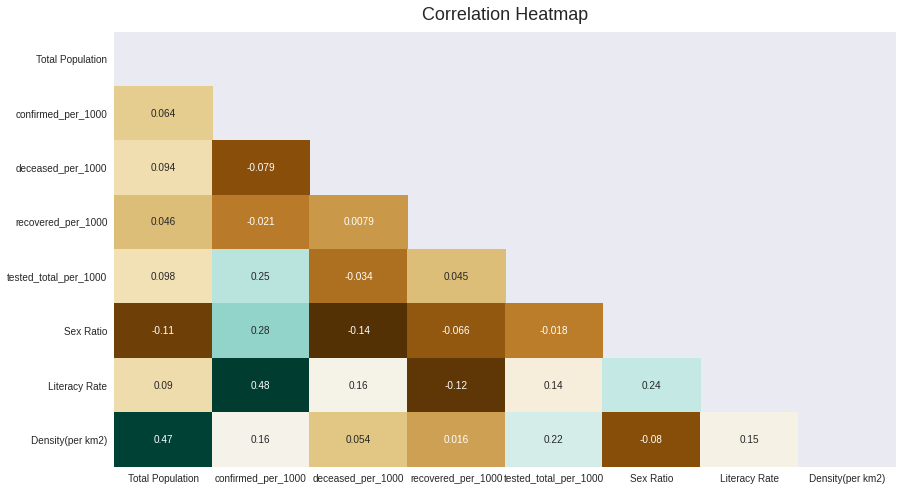

In [34]:
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(14,8))
heatmap = sns.heatmap(corr,annot=True,cbar=False,mask=mask,cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

## Do confirmed cases correlate with district population density ?

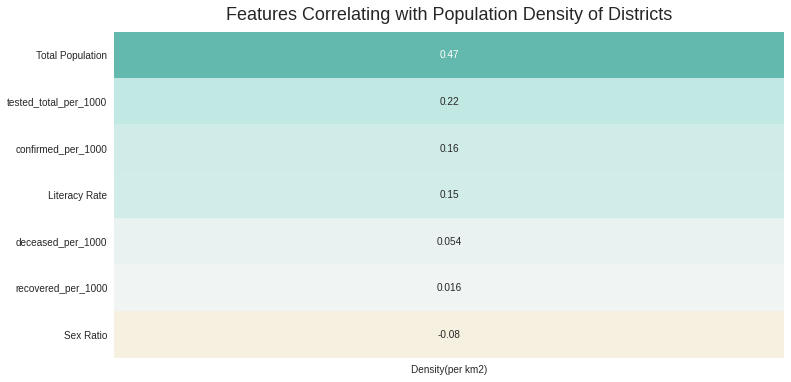

In [35]:
plt.figure(figsize=(12,6))
heatmap = sns.heatmap(corr[['Density(per km2)']].drop('Density(per km2)',axis=0).sort_values(by='Density(per km2)', ascending=False), vmin=-1, vmax=1, annot=True,cmap='BrBG',cbar=False)
heatmap.set_title('Features Correlating with Population Density of Districts', fontdict={'fontsize':18}, pad=12);

In [36]:
ind_stats_daily_latest = ind_stats_daily.select("state|population|confirmed_total_relative|deceased_total_relative|recovered_total_relative|vaccinated1_total_relative|vaccinated2_total_relative".split("|"))\
                  .where(col('days_since_first_case') == ind_stats_daily.select("days_since_first_case").rdd.max()[0]).toPandas()

state_census = pd.read_csv('./covid19_data/india-states-statistics.csv').drop(['latitude','longitude','Population'],axis=1)

ind_stats_daily_latest.head(5)

state  population  confirmed_total_relative  \
0  Andaman and Nicobar Islands      417036                      1.83   
1               Andhra Pradesh    53903393                      3.82   
2                        Assam    35607039                      1.70   
3                        Bihar   124799926                      0.58   
4                   Chandigarh     1158473                      5.64   

   deceased_total_relative  recovered_total_relative  \
0                     1.79                     98.21   
1                     1.03                     98.97   
2                     1.64                     98.36   
3                     1.34                     98.66   
4                     1.32                     98.68   

   vaccinated1_total_relative  vaccinated2_total_relative  
0                       69.94                       40.32  
1                       54.30                       29.13  
2                       55.26                       18.23  
3                       37.74                       11.21  
4                       78.97                       42.31

In [37]:
ind_state_census = pd.merge(ind_stats_daily_latest,state_census,on='state')
ind_state_census.columns = "state|population|confirmed_per_1000|deceased_per_1000|recovered_per_1000|vaccinated1_per_1000|vaccinated2_per_1000|Sex ratio|Area(km2)|Density(per km2)|Literacy Rate".split("|")
# ind_state_census

In [38]:
numeric_cols = "confirmed_per_1000|deceased_per_1000|recovered_per_1000|vaccinated1_per_1000|vaccinated2_per_1000|Sex ratio|Area(km2)|Density(per km2)|Literacy Rate".split("|")
corr = ind_state_census[numeric_cols].corr()
corr

confirmed_per_1000  deceased_per_1000  \
confirmed_per_1000              1.000000           0.287988   
deceased_per_1000               0.287988           1.000000   
recovered_per_1000             -0.287988          -1.000000   
vaccinated1_per_1000            0.469110          -0.093755   
vaccinated2_per_1000            0.566931           0.184780   
Sex ratio                      -0.156167           0.105674   
Area(km2)                      -0.339294          -0.270720   
Density(per km2)                0.287022          -0.140667   
Literacy Rate                   0.470397           0.420480   

                      recovered_per_1000  vaccinated1_per_1000  \
confirmed_per_1000             -0.287988              0.469110   
deceased_per_1000              -1.000000             -0.093755   
recovered_per_1000              1.000000              0.093755   
vaccinated1_per_1000            0.093755              1.000000   
vaccinated2_per_1000           -0.184780              0.881564   
Sex ratio                      -0.105674             -0.437284   
Area(km2)                       0.270720             -0.278306   
Density(per km2)                0.140667              0.327968   
Literacy Rate                  -0.420480              0.449273   

                      vaccinated2_per_1000  Sex ratio  Area(km2)  \
confirmed_per_1000                0.566931  -0.156167  -0.339294   
deceased_per_1000                 0.184780   0.105674  -0.270720   
recovered_per_1000               -0.184780  -0.105674   0.270720   
vaccinated1_per_1000              0.881564  -0.437284  -0.278306   
vaccinated2_per_1000              1.000000  -0.426693  -0.440198   
Sex ratio                        -0.426693   1.000000   0.206404   
Area(km2)                        -0.440198   0.206404   1.000000   
Density(per km2)                  0.290018  -0.781066  -0.290256   
Literacy Rate                     0.635975  -0.302498  -0.566053   

                      Density(per km2)  Literacy Rate  
confirmed_per_1000            0.287022       0.470397  
deceased_per_1000            -0.140667       0.420480  
recovered_per_1000            0.140667      -0.420480  
vaccinated1_per_1000          0.327968       0.449273  
vaccinated2_per_1000          0.290018       0.635975  
Sex ratio                    -0.781066      -0.302498  
Area(km2)                    -0.290256      -0.566053  
Density(per km2)              1.000000       0.332036  
Literacy Rate                 0.332036       1.000000

## Correlation heatmap between metrics for states

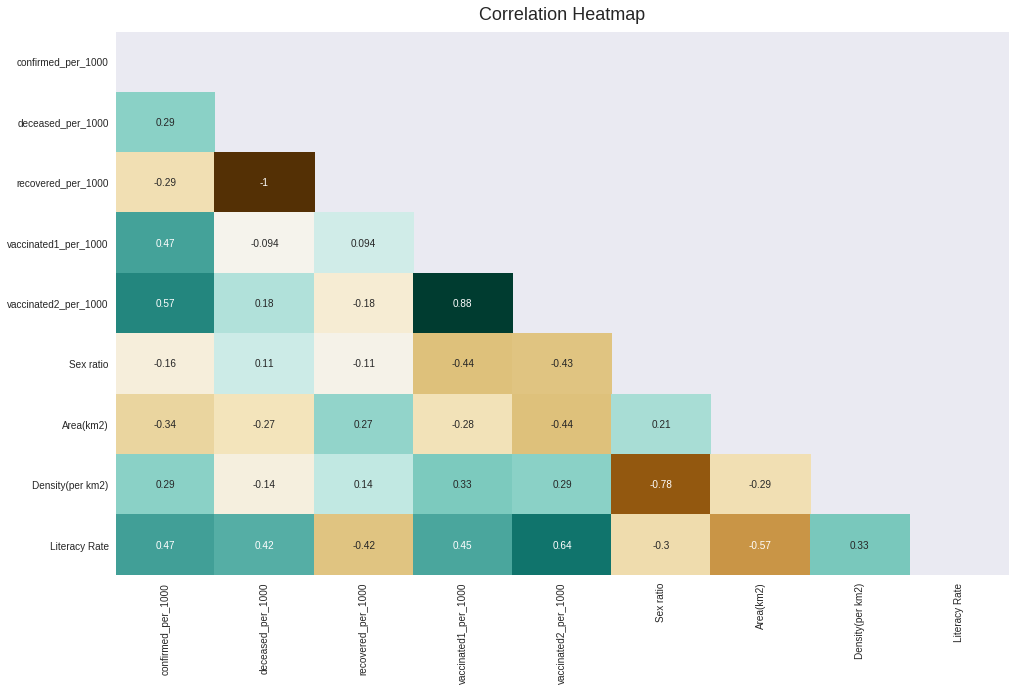

In [39]:
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(16,10))
heatmap = sns.heatmap(corr,annot=True,cbar=False,mask=mask,cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

## Do confirmed cases correlate with state population density ?

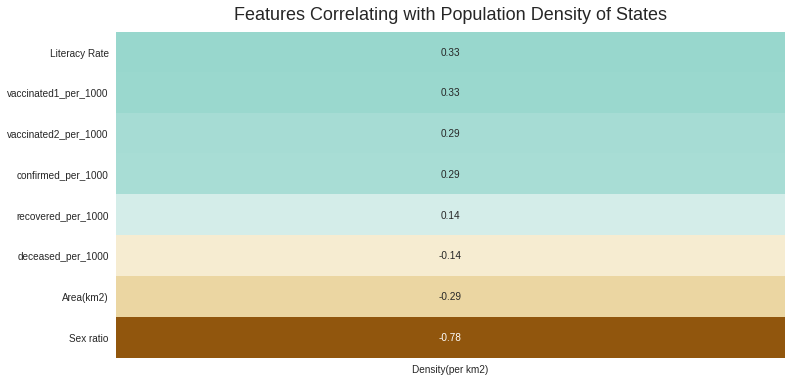

In [40]:
plt.figure(figsize=(12,6))
heatmap = sns.heatmap(corr[['Density(per km2)']].drop('Density(per km2)',axis=0).sort_values(by='Density(per km2)', ascending=False), vmin=-1, vmax=1, annot=True,cmap='BrBG',cbar=False)
heatmap.set_title('Features Correlating with Population Density of States', fontdict={'fontsize':18}, pad=12);

## Does state literacy rate correlate with vaccination rate ?

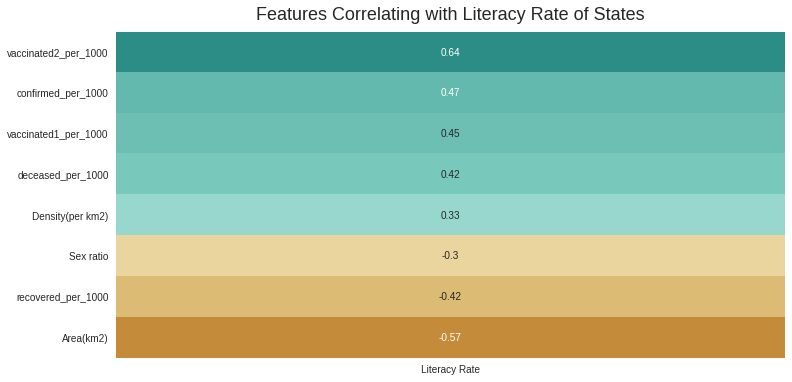

In [41]:
plt.figure(figsize=(12,6))
heatmap = sns.heatmap(corr[['Literacy Rate']].drop('Literacy Rate',axis=0).sort_values(by='Literacy Rate', ascending=False), vmin=-1, vmax=1, annot=True,cmap='BrBG',cbar=False)
heatmap.set_title('Features Correlating with Literacy Rate of States', fontdict={'fontsize':18}, pad=12);